# Tree-Based Models: Decision Tree, Random Forest, and Gradient Boosting

This notebook implements three tree-based models with GridSearchCV hyperparameter tuning:
1. **Decision Tree** - Interpretable single tree model
2. **Random Forest** - Ensemble of decision trees (n_estimators=300)
3. **Gradient Boosting** - Sequential ensemble with boosting

Each model is trained and evaluated on three datasets:
- **Raw/Original** dataset (imbalanced)
- **SMOTE Balanced** dataset (synthetic oversampling)
- **ADASYN Balanced** dataset (adaptive synthetic oversampling)

**Approach:**
- GridSearchCV with recall scoring (critical for HR attrition prediction)
- Centralized metrics storage for all model-dataset combinations
- Feature importance extraction for all models

**Prerequisites:** Run notebook 01 (data exploration) first to generate the processed data files.


## Load Processed Data from Notebook 01

The following cell loads the pre-processed and scaled dataframe from notebook 01. This ensures we're working with the same processed data without re-running all data cleaning and feature engineering steps.


In [12]:
# ============================================================
# Load Processed Data from Notebook 01
# ============================================================

import pickle
import pandas as pd
import numpy as np
import os

# Check if processed data exists
data_dir = "../data/processed"
pkl_path = f"{data_dir}/df_scaled.pkl"

if os.path.exists(pkl_path):
    # Load the processed dataframe
    with open(pkl_path, "rb") as f:
        df_scaled = pickle.load(f)
    
    # Load the scaler (if needed for future transformations)
    scaler_path = f"{data_dir}/scaler.pkl"
    if os.path.exists(scaler_path):
        with open(scaler_path, "rb") as f:
            scaler = pickle.load(f)
    
    print("=" * 70)
    print("PROCESSED DATA LOADED SUCCESSFULLY")
    print("=" * 70)
    print(f" Loaded from: {pkl_path}")
    print(f" DataFrame shape: {df_scaled.shape}")
    print(f" Columns: {df_scaled.shape[1]}")
    print(f" Rows: {df_scaled.shape[0]}")
    print(f"\nFirst few columns: {list(df_scaled.columns[:10])}")
    print(f"\nAttrition distribution:")
    print(df_scaled["Attrition"].value_counts())
    print(f"\n Data ready for modeling!")
    print("=" * 70)
    
else:
    raise FileNotFoundError(
        f"\n{'='*70}\n"
        f"PROCESSED DATA NOT FOUND\n"
        f"{'='*70}\n"
        f"File not found: {pkl_path}\n\n"
        f"Please run notebook 01 (01-data-exploration.ipynb) first:\n"
        f"1. Execute all cells in notebook 01\n"
        f"2. This will save the processed data to {data_dir}/\n"
        f"3. Then return to this notebook\n"
        f"{'='*70}"
    )


PROCESSED DATA LOADED SUCCESSFULLY
 Loaded from: ../data/processed/df_scaled.pkl
 DataFrame shape: (1470, 29)
 Columns: 29
 Rows: 1470

First few columns: ['Attrition', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobSatisfaction', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike']

Attrition distribution:
Attrition
0    1233
1     237
Name: count, dtype: int64

 Data ready for modeling!


## Step 1: Prepare Three Response Variable Sets

Same as notebook 02 - we'll create three training sets (Raw, SMOTE, ADASYN) for fair comparison.


In [13]:
# ============================================================
# Step 1: Prepare Three Response Variable Sets
# ============================================================

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# ---------------------------------------
# 1.1: Initial Train-Test Split (Same for All Three Sets)
# ---------------------------------------
X = df_scaled.drop(columns=["Attrition"])
y = df_scaled["Attrition"]

# Split once - we'll use same test set for all models
X_train_base, X_test, y_train_base, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("=" * 70)
print("PREPARING THREE RESPONSE VARIABLE SETS")
print("=" * 70)

# Display original class distribution
print("\n--- ORIGINAL TRAINING SET DISTRIBUTION ---")
print(f"Class 0 (No Attrition):  {(y_train_base == 0).sum()} ({(y_train_base == 0).mean()*100:.1f}%)")
print(f"Class 1 (Attrition):      {(y_train_base == 1).sum()} ({(y_train_base == 1).mean()*100:.1f}%)")
print(f"Imbalance Ratio:          {(y_train_base == 0).sum() / (y_train_base == 1).sum():.2f}:1")

# ---------------------------------------
# 1.2: Set 1 - Raw/Original (No Balancing)
# ---------------------------------------
X_train_raw = X_train_base.copy()
y_train_raw = y_train_base.copy()

print("\n--- SET 1: RAW/ORIGINAL (No Balancing) ---")
print(f"Class 0: {(y_train_raw == 0).sum()} | Class 1: {(y_train_raw == 1).sum()}")
print(f"Ratio: {(y_train_raw == 0).sum() / (y_train_raw == 1).sum():.2f}:1")

# ---------------------------------------
# 1.3: Set 2 - SMOTE Balanced
# ---------------------------------------
print("\n--- SET 2: SMOTE BALANCED ---")
smote = SMOTE(
    random_state=42,
    k_neighbors=5,
    sampling_strategy='auto'  # Balances to 50:50
)

X_train_smote, y_train_smote = smote.fit_resample(X_train_base, y_train_base)

print(f"Class 0: {(y_train_smote == 0).sum()} | Class 1: {(y_train_smote == 1).sum()}")
print(f"Ratio: {(y_train_smote == 0).sum() / (y_train_smote == 1).sum():.2f}:1")
print(f"SMOTE generated {(y_train_smote == 1).sum() - (y_train_base == 1).sum()} synthetic samples")

# ---------------------------------------
# 1.4: Set 3 - ADASYN Balanced
# ---------------------------------------
print("\n--- SET 3: ADASYN BALANCED ---")
adasyn = ADASYN(
    random_state=42,
    n_neighbors=5,
    sampling_strategy='auto'
)

X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_base, y_train_base)

print(f"Class 0: {(y_train_adasyn == 0).sum()} | Class 1: {(y_train_adasyn == 1).sum()}")
print(f"Ratio: {(y_train_adasyn == 0).sum() / (y_train_adasyn == 1).sum():.2f}:1")
print(f"ADASYN generated {(y_train_adasyn == 1).sum() - (y_train_base == 1).sum()} synthetic samples")

# ---------------------------------------
# 1.5: Store All Three Sets in Dictionary for Easy Access
# ---------------------------------------
training_sets = {
    'raw': {
        'X_train': X_train_raw,
        'y_train': y_train_raw,
        'name': 'Raw/Original',
        'description': 'Original imbalanced dataset (no resampling)'
    },
    'smote': {
        'X_train': X_train_smote,
        'y_train': y_train_smote,
        'name': 'SMOTE Balanced',
        'description': 'Synthetic Minority Oversampling Technique - uniform synthetic generation'
    },
    'adasyn': {
        'X_train': X_train_adasyn,
        'y_train': y_train_adasyn,
        'name': 'ADASYN Balanced',
        'description': 'Adaptive Synthetic Sampling - focuses on harder-to-learn minority samples'
    }
}

print("\n" + "=" * 70)
print("THREE RESPONSE VARIABLE SETS PREPARED SUCCESSFULLY")
print("=" * 70)
print("\nAll sets use the same test set for fair comparison:")
print(f"Test set - Class 0: {(y_test == 0).sum()} | Class 1: {(y_test == 1).sum()}")


PREPARING THREE RESPONSE VARIABLE SETS

--- ORIGINAL TRAINING SET DISTRIBUTION ---
Class 0 (No Attrition):  863 (83.9%)
Class 1 (Attrition):      166 (16.1%)
Imbalance Ratio:          5.20:1

--- SET 1: RAW/ORIGINAL (No Balancing) ---
Class 0: 863 | Class 1: 166
Ratio: 5.20:1

--- SET 2: SMOTE BALANCED ---
Class 0: 863 | Class 1: 863
Ratio: 1.00:1
SMOTE generated 697 synthetic samples

--- SET 3: ADASYN BALANCED ---
Class 0: 863 | Class 1: 851
Ratio: 1.01:1
ADASYN generated 685 synthetic samples

THREE RESPONSE VARIABLE SETS PREPARED SUCCESSFULLY

All sets use the same test set for fair comparison:
Test set - Class 0: 370 | Class 1: 71


/Users/satkarkarki/Desktop/portfolio/hr-attrition/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/satkarkarki/Desktop/portfolio/hr-attrition/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


## Step 2: Imports and Unified Modeling Pipeline

Import required libraries and create a unified function for training models with GridSearchCV that will be reused for all three model types.


In [14]:
# ============================================================
# Step 2: Imports and Unified Modeling Pipeline
# ============================================================

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
import pandas as pd
import numpy as np

def evaluate_model(y_test, y_pred, y_prob):
    """
    Calculate all required evaluation metrics including confusion matrix components.
    
    Parameters:
    -----------
    y_test : array
        True labels
    y_pred : array
        Predicted labels
    y_prob : array
        Predicted probabilities for positive class
        
    Returns:
    --------
    dict : Dictionary with accuracy, precision, recall, f1, roc_auc, and confusion matrix components
    """
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'confusion_matrix': cm,
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp)
    }


def train_model_with_gridsearch(model_class, param_grid, X_train, y_train, X_test, y_test,
                                model_name, dataset_name, **model_kwargs):
    """
    Unified function to train any model with GridSearchCV.
    
    Parameters:
    -----------
    model_class : sklearn estimator class
        Model class to instantiate (e.g., DecisionTreeClassifier)
    param_grid : dict
        Parameter grid for GridSearchCV
    X_train : DataFrame/array
        Training features
    y_train : Series/array
        Training labels
    X_test : DataFrame/array
        Test features
    y_test : Series/array
        Test labels
    model_name : str
        Name of the model type (e.g., 'DecisionTree')
    dataset_name : str
        Name of the dataset (e.g., 'raw', 'smote', 'adasyn')
    **model_kwargs : dict
        Additional keyword arguments for model initialization
        
    Returns:
    --------
    dict : Dictionary containing best_estimator, metrics, feature_importance, best_params
    """
    import inspect
    
    # Check if model accepts random_state parameter
    sig = inspect.signature(model_class.__init__)
    accepts_random_state = 'random_state' in sig.parameters
    
    # Build initialization parameters
    init_params = {}
    if accepts_random_state and 'random_state' not in model_kwargs:
        init_params['random_state'] = 42
    
    # Add any additional kwargs (these will override defaults if they conflict)
    init_params.update(model_kwargs)
    
    # Initialize model
    model = model_class(**init_params)
    
    # GridSearchCV with f1 scoring (balanced metric for imbalanced data)
    # Note: We use f1 for hyperparameter tuning but track all metrics (precision, recall, f1, roc_auc)
    # GridSearchCV doesn't accept random_state in this sklearn version
    # Randomness is controlled by the model's random_state parameter
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',  # Use f1 for balanced optimization, but we'll analyze recall in detail
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    print(f"  Running GridSearchCV for {model_name} on {dataset_name} dataset...")
    grid_search.fit(X_train, y_train)
    
    # Get best estimator
    best_estimator = grid_search.best_estimator_
    
    # Evaluate on test set
    y_test_pred = best_estimator.predict(X_test)
    y_test_prob = best_estimator.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = evaluate_model(y_test, y_test_pred, y_test_prob)
    
    # Extract feature importance (only if model has this attribute)
    if hasattr(best_estimator, 'feature_importances_'):
        feature_importance = pd.Series(
            best_estimator.feature_importances_,
            index=X_train.columns if hasattr(X_train, 'columns') else range(X_train.shape[1])
        ).sort_values(ascending=False)
    else:
        # For models without feature_importances_ (like SVC, MLP), return empty Series
        feature_importance = pd.Series(dtype=float)
    
    print(f"  Best parameters: {grid_search.best_params_}")
    print(f"  Test Metrics - Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}, ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"  Confusion Matrix - TN: {metrics['tn']}, FP: {metrics['fp']}, FN: {metrics['fn']}, TP: {metrics['tp']}")
    
    return {
        'best_estimator': best_estimator,
        'metrics': metrics,
        'feature_importance': feature_importance,
        'best_params': grid_search.best_params_
    }


## Step 3: Initialize Centralized Storage

Initialize data structures to store metrics and feature importances for all model-dataset combinations.


In [15]:
# ============================================================
# Step 3: Initialize Centralized Storage
# ============================================================

# List to store all metrics (will become DataFrame)
all_metrics = []

# Dictionary to store feature importances
# Structure: {model_name: {dataset: Series}}
all_feature_importances = {}

# Dictionary to store best estimators
# Structure: {model_name: {dataset: estimator}}
best_estimators = {}

print("=" * 70)
print("CENTRALIZED STORAGE INITIALIZED")
print("=" * 70)
print("all_metrics: List for storing metrics (will become DataFrame)")
print("all_feature_importances: Dictionary for feature importance storage")
print("best_estimators: Dictionary for storing best fitted models")
print("=" * 70)


CENTRALIZED STORAGE INITIALIZED
all_metrics: List for storing metrics (will become DataFrame)
all_feature_importances: Dictionary for feature importance storage
best_estimators: Dictionary for storing best fitted models


## Step 4: Decision Tree with GridSearchCV

Train Decision Tree models with GridSearchCV hyperparameter tuning on all three datasets.


In [16]:
# ============================================================
# Step 4: Decision Tree with GridSearchCV
# ============================================================

# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("=" * 70)
print("DECISION TREE WITH GRIDSEARCHCV")
print("=" * 70)
print(f"\nParameter Grid:")
for param, values in dt_param_grid.items():
    print(f"  {param}: {values}")

# Initialize storage for Decision Tree
best_estimators['DecisionTree'] = {}
all_feature_importances['DecisionTree'] = {}

# Train on each dataset
for dataset_key, dataset_data in training_sets.items():
    print(f"\n{'='*70}")
    print(f"Training Decision Tree on: {dataset_data['name']}")
    print(f"{'='*70}")
    
    result = train_model_with_gridsearch(
        model_class=DecisionTreeClassifier,
        param_grid=dt_param_grid,
        X_train=dataset_data['X_train'],
        y_train=dataset_data['y_train'],
        X_test=X_test,
        y_test=y_test,
        model_name='DecisionTree',
        dataset_name=dataset_key,
        class_weight='balanced' if dataset_key == 'raw' else None
    )
    
    # Store best estimator
    best_estimators['DecisionTree'][dataset_key] = result['best_estimator']
    
    # Store feature importance
    all_feature_importances['DecisionTree'][dataset_key] = result['feature_importance']
    
    # Store metrics with confusion matrix components
    all_metrics.append({
        'model': 'DecisionTree',
        'dataset': dataset_data['name'],
        'accuracy': result['metrics']['accuracy'],
        'precision': result['metrics']['precision'],
        'recall': result['metrics']['recall'],
        'f1': result['metrics']['f1'],
        'roc_auc': result['metrics']['roc_auc'],
        'tn': result['metrics']['tn'],
        'fp': result['metrics']['fp'],
        'fn': result['metrics']['fn'],
        'tp': result['metrics']['tp']
    })

print(f"\n{'='*70}")
print("DECISION TREE TRAINING COMPLETE")
print(f"{'='*70}")


DECISION TREE WITH GRIDSEARCHCV

Parameter Grid:
  max_depth: [3, 5, 7, 10, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]

Training Decision Tree on: Raw/Original
  Running GridSearchCV for DecisionTree on raw dataset...
Fitting 5 folds for each of 45 candidates, totalling 225 fits
  Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
  Test Metrics - Accuracy: 0.7279, Precision: 0.3262, Recall: 0.6479, F1: 0.4340, ROC-AUC: 0.6930
  Confusion Matrix - TN: 275, FP: 95, FN: 25, TP: 46

Training Decision Tree on: SMOTE Balanced
  Running GridSearchCV for DecisionTree on smote dataset...
Fitting 5 folds for each of 45 candidates, totalling 225 fits
  Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Test Metrics - Accuracy: 0.7370, Precision: 0.2632, Recall: 0.3521, F1: 0.3012, ROC-AUC: 0.6064
  Confusion Matrix - TN: 300, FP: 70, FN: 46, TP: 25

Training Decision Tree on: ADASYN Balanced
  Running GridSea

## Step 5: Random Forest with GridSearchCV

Train Random Forest models with GridSearchCV hyperparameter tuning. n_estimators is fixed at 300.


In [17]:
# ============================================================
# Step 5: Random Forest with GridSearchCV
# ============================================================

# Define parameter grid for Random Forest
rf_param_grid = {
    'max_depth': [5, 10, 15, None],
    'max_features': ['sqrt', 'log2', 0.5],
    'min_samples_leaf': [1, 2, 4]
}

print("=" * 70)
print("RANDOM FOREST WITH GRIDSEARCHCV")
print("=" * 70)
print(f"\nParameter Grid:")
for param, values in rf_param_grid.items():
    print(f"  {param}: {values}")
print(f"\nFixed Parameter: n_estimators = 300")

# Initialize storage for Random Forest
best_estimators['RandomForest'] = {}
all_feature_importances['RandomForest'] = {}

# Train on each dataset
for dataset_key, dataset_data in training_sets.items():
    print(f"\n{'='*70}")
    print(f"Training Random Forest on: {dataset_data['name']}")
    print(f"{'='*70}")
    
    result = train_model_with_gridsearch(
        model_class=RandomForestClassifier,
        param_grid=rf_param_grid,
        X_train=dataset_data['X_train'],
        y_train=dataset_data['y_train'],
        X_test=X_test,
        y_test=y_test,
        model_name='RandomForest',
        dataset_name=dataset_key,
        n_estimators=300,
        class_weight='balanced' if dataset_key == 'raw' else None
    )
    
    # Store best estimator
    best_estimators['RandomForest'][dataset_key] = result['best_estimator']
    
    # Store feature importance
    all_feature_importances['RandomForest'][dataset_key] = result['feature_importance']
    
    # Store metrics with confusion matrix components
    all_metrics.append({
        'model': 'RandomForest',
        'dataset': dataset_data['name'],
        'accuracy': result['metrics']['accuracy'],
        'precision': result['metrics']['precision'],
        'recall': result['metrics']['recall'],
        'f1': result['metrics']['f1'],
        'roc_auc': result['metrics']['roc_auc'],
        'tn': result['metrics']['tn'],
        'fp': result['metrics']['fp'],
        'fn': result['metrics']['fn'],
        'tp': result['metrics']['tp']
    })

print(f"\n{'='*70}")
print("RANDOM FOREST TRAINING COMPLETE")
print(f"{'='*70}")


RANDOM FOREST WITH GRIDSEARCHCV

Parameter Grid:
  max_depth: [5, 10, 15, None]
  max_features: ['sqrt', 'log2', 0.5]
  min_samples_leaf: [1, 2, 4]

Fixed Parameter: n_estimators = 300

Training Random Forest on: Raw/Original
  Running GridSearchCV for RandomForest on raw dataset...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
  Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4}
  Test Metrics - Accuracy: 0.8118, Precision: 0.4268, Recall: 0.4930, F1: 0.4575, ROC-AUC: 0.7697
  Confusion Matrix - TN: 323, FP: 47, FN: 36, TP: 35

Training Random Forest on: SMOTE Balanced
  Running GridSearchCV for RandomForest on smote dataset...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
  Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1}
  Test Metrics - Accuracy: 0.8413, Precision: 0.5152, Recall: 0.2394, F1: 0.3269, ROC-AUC: 0.7340
  Confusion Matrix - TN: 354, FP: 16, FN: 54, TP: 17

Training Random F

## Step 6: Gradient Boosting with GridSearchCV

Train Gradient Boosting models with GridSearchCV hyperparameter tuning using paired learning_rate and n_estimators.


In [18]:
# ============================================================
# Step 6: Gradient Boosting with GridSearchCV
# ============================================================

# Define parameter grid for Gradient Boosting
gb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

print("=" * 70)
print("GRADIENT BOOSTING WITH GRIDSEARCHCV")
print("=" * 70)
print(f"\nParameter Grid:")
for param, values in gb_param_grid.items():
    print(f"  {param}: {values}")

# Initialize storage for Gradient Boosting
best_estimators['GradientBoosting'] = {}
all_feature_importances['GradientBoosting'] = {}

# Train on each dataset
for dataset_key, dataset_data in training_sets.items():
    print(f"\n{'='*70}")
    print(f"Training Gradient Boosting on: {dataset_data['name']}")
    print(f"{'='*70}")
    
    result = train_model_with_gridsearch(
        model_class=GradientBoostingClassifier,
        param_grid=gb_param_grid,
        X_train=dataset_data['X_train'],
        y_train=dataset_data['y_train'],
        X_test=X_test,
        y_test=y_test,
        model_name='GradientBoosting',
        dataset_name=dataset_key
    )
    
    # Store best estimator
    best_estimators['GradientBoosting'][dataset_key] = result['best_estimator']
    
    # Store feature importance
    all_feature_importances['GradientBoosting'][dataset_key] = result['feature_importance']
    
    # Store metrics with confusion matrix components
    all_metrics.append({
        'model': 'GradientBoosting',
        'dataset': dataset_data['name'],
        'accuracy': result['metrics']['accuracy'],
        'precision': result['metrics']['precision'],
        'recall': result['metrics']['recall'],
        'f1': result['metrics']['f1'],
        'roc_auc': result['metrics']['roc_auc'],
        'tn': result['metrics']['tn'],
        'fp': result['metrics']['fp'],
        'fn': result['metrics']['fn'],
        'tp': result['metrics']['tp']
    })

print(f"\n{'='*70}")
print("GRADIENT BOOSTING TRAINING COMPLETE")
print(f"{'='*70}")


GRADIENT BOOSTING WITH GRIDSEARCHCV

Parameter Grid:
  learning_rate: [0.01, 0.1, 0.2]
  n_estimators: [100, 200, 300]
  max_depth: [3, 5, 7]

Training Gradient Boosting on: Raw/Original
  Running GridSearchCV for GradientBoosting on raw dataset...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
  Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}
  Test Metrics - Accuracy: 0.8413, Precision: 0.5111, Recall: 0.3239, F1: 0.3966, ROC-AUC: 0.7488
  Confusion Matrix - TN: 348, FP: 22, FN: 48, TP: 23

Training Gradient Boosting on: SMOTE Balanced
  Running GridSearchCV for GradientBoosting on smote dataset...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
  Best parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300}
  Test Metrics - Accuracy: 0.8118, Precision: 0.3966, Recall: 0.3239, F1: 0.3566, ROC-AUC: 0.7131
  Confusion Matrix - TN: 335, FP: 35, FN: 48, TP: 23

Training Gradient Boosting on: ADASYN Balanced
  Runni

## Step 7: Centralized Metrics Table

Display the final metrics table with all model-dataset combinations.


In [19]:
# ============================================================
# Step 7: Centralized Metrics Table with All Metrics
# ============================================================

# Convert metrics list to DataFrame
metrics_df = pd.DataFrame(all_metrics)

print("=" * 70)
print("CENTRALIZED METRICS TABLE")
print("=" * 70)
print(f"\nTotal model-dataset combinations: {len(metrics_df)}")

if len(metrics_df) > 0:
    print(f"Models: {metrics_df['model'].unique().tolist()}")
    print(f"Datasets: {metrics_df['dataset'].unique().tolist()}")

    print("\n" + "=" * 70)
    print("COMPREHENSIVE METRICS TABLE (All Models and Datasets)")
    print("=" * 70)
    
    # Display main metrics
    display_cols = ['model', 'dataset', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    print("\n--- PERFORMANCE METRICS ---")
    print(metrics_df[display_cols].to_string(index=False))
    
    # Display confusion matrix components
    print("\n--- CONFUSION MATRIX COMPONENTS ---")
    cm_cols = ['model', 'dataset', 'tn', 'fp', 'fn', 'tp']
    print(metrics_df[cm_cols].to_string(index=False))
    
    # Display summary statistics by model
    print("\n" + "=" * 70)
    print("SUMMARY STATISTICS BY MODEL")
    print("=" * 70)
    for model in metrics_df['model'].unique():
        model_data = metrics_df[metrics_df['model'] == model]
        print(f"\n{model}:")
        print(f"  Accuracy:  {model_data['accuracy'].mean():.4f} (std: {model_data['accuracy'].std():.4f})")
        print(f"  Precision: {model_data['precision'].mean():.4f} (std: {model_data['precision'].std():.4f})")
        print(f"  Recall:    {model_data['recall'].mean():.4f} (std: {model_data['recall'].std():.4f})")
        print(f"  F1 Score:  {model_data['f1'].mean():.4f} (std: {model_data['f1'].std():.4f})")
        print(f"  ROC-AUC:   {model_data['roc_auc'].mean():.4f} (std: {model_data['roc_auc'].std():.4f})")

    print("\n" + "=" * 70)
    print("SUMMARY STATISTICS BY DATASET")
    print("=" * 70)
    for dataset in metrics_df['dataset'].unique():
        dataset_data = metrics_df[metrics_df['dataset'] == dataset]
        print(f"\n{dataset}:")
        print(f"  Accuracy:  {dataset_data['accuracy'].mean():.4f} (std: {dataset_data['accuracy'].std():.4f})")
        print(f"  Precision: {dataset_data['precision'].mean():.4f} (std: {dataset_data['precision'].std():.4f})")
        print(f"  Recall:    {dataset_data['recall'].mean():.4f} (std: {dataset_data['recall'].std():.4f})")
        print(f"  F1 Score:  {dataset_data['f1'].mean():.4f} (std: {dataset_data['f1'].std():.4f})")
        print(f"  ROC-AUC:   {dataset_data['roc_auc'].mean():.4f} (std: {dataset_data['roc_auc'].std():.4f})")
else:
    print("\nNo metrics available yet. Please run model training cells first.")


CENTRALIZED METRICS TABLE

Total model-dataset combinations: 9
Models: ['DecisionTree', 'RandomForest', 'GradientBoosting']
Datasets: ['Raw/Original', 'SMOTE Balanced', 'ADASYN Balanced']

COMPREHENSIVE METRICS TABLE (All Models and Datasets)

--- PERFORMANCE METRICS ---
           model         dataset  accuracy  precision   recall       f1  roc_auc
    DecisionTree    Raw/Original  0.727891   0.326241 0.647887 0.433962 0.692977
    DecisionTree  SMOTE Balanced  0.736961   0.263158 0.352113 0.301205 0.606395
    DecisionTree ADASYN Balanced  0.736961   0.252747 0.323944 0.283951 0.570080
    RandomForest    Raw/Original  0.811791   0.426829 0.492958 0.457516 0.769661
    RandomForest  SMOTE Balanced  0.841270   0.515152 0.239437 0.326923 0.733993
    RandomForest ADASYN Balanced  0.843537   0.533333 0.225352 0.316832 0.720537
GradientBoosting    Raw/Original  0.841270   0.511111 0.323944 0.396552 0.748763
GradientBoosting  SMOTE Balanced  0.811791   0.396552 0.323944 0.356589 0.713095

## Step 8: Comprehensive Model Comparison

Compare all models across all metrics with visualizations and detailed analysis.


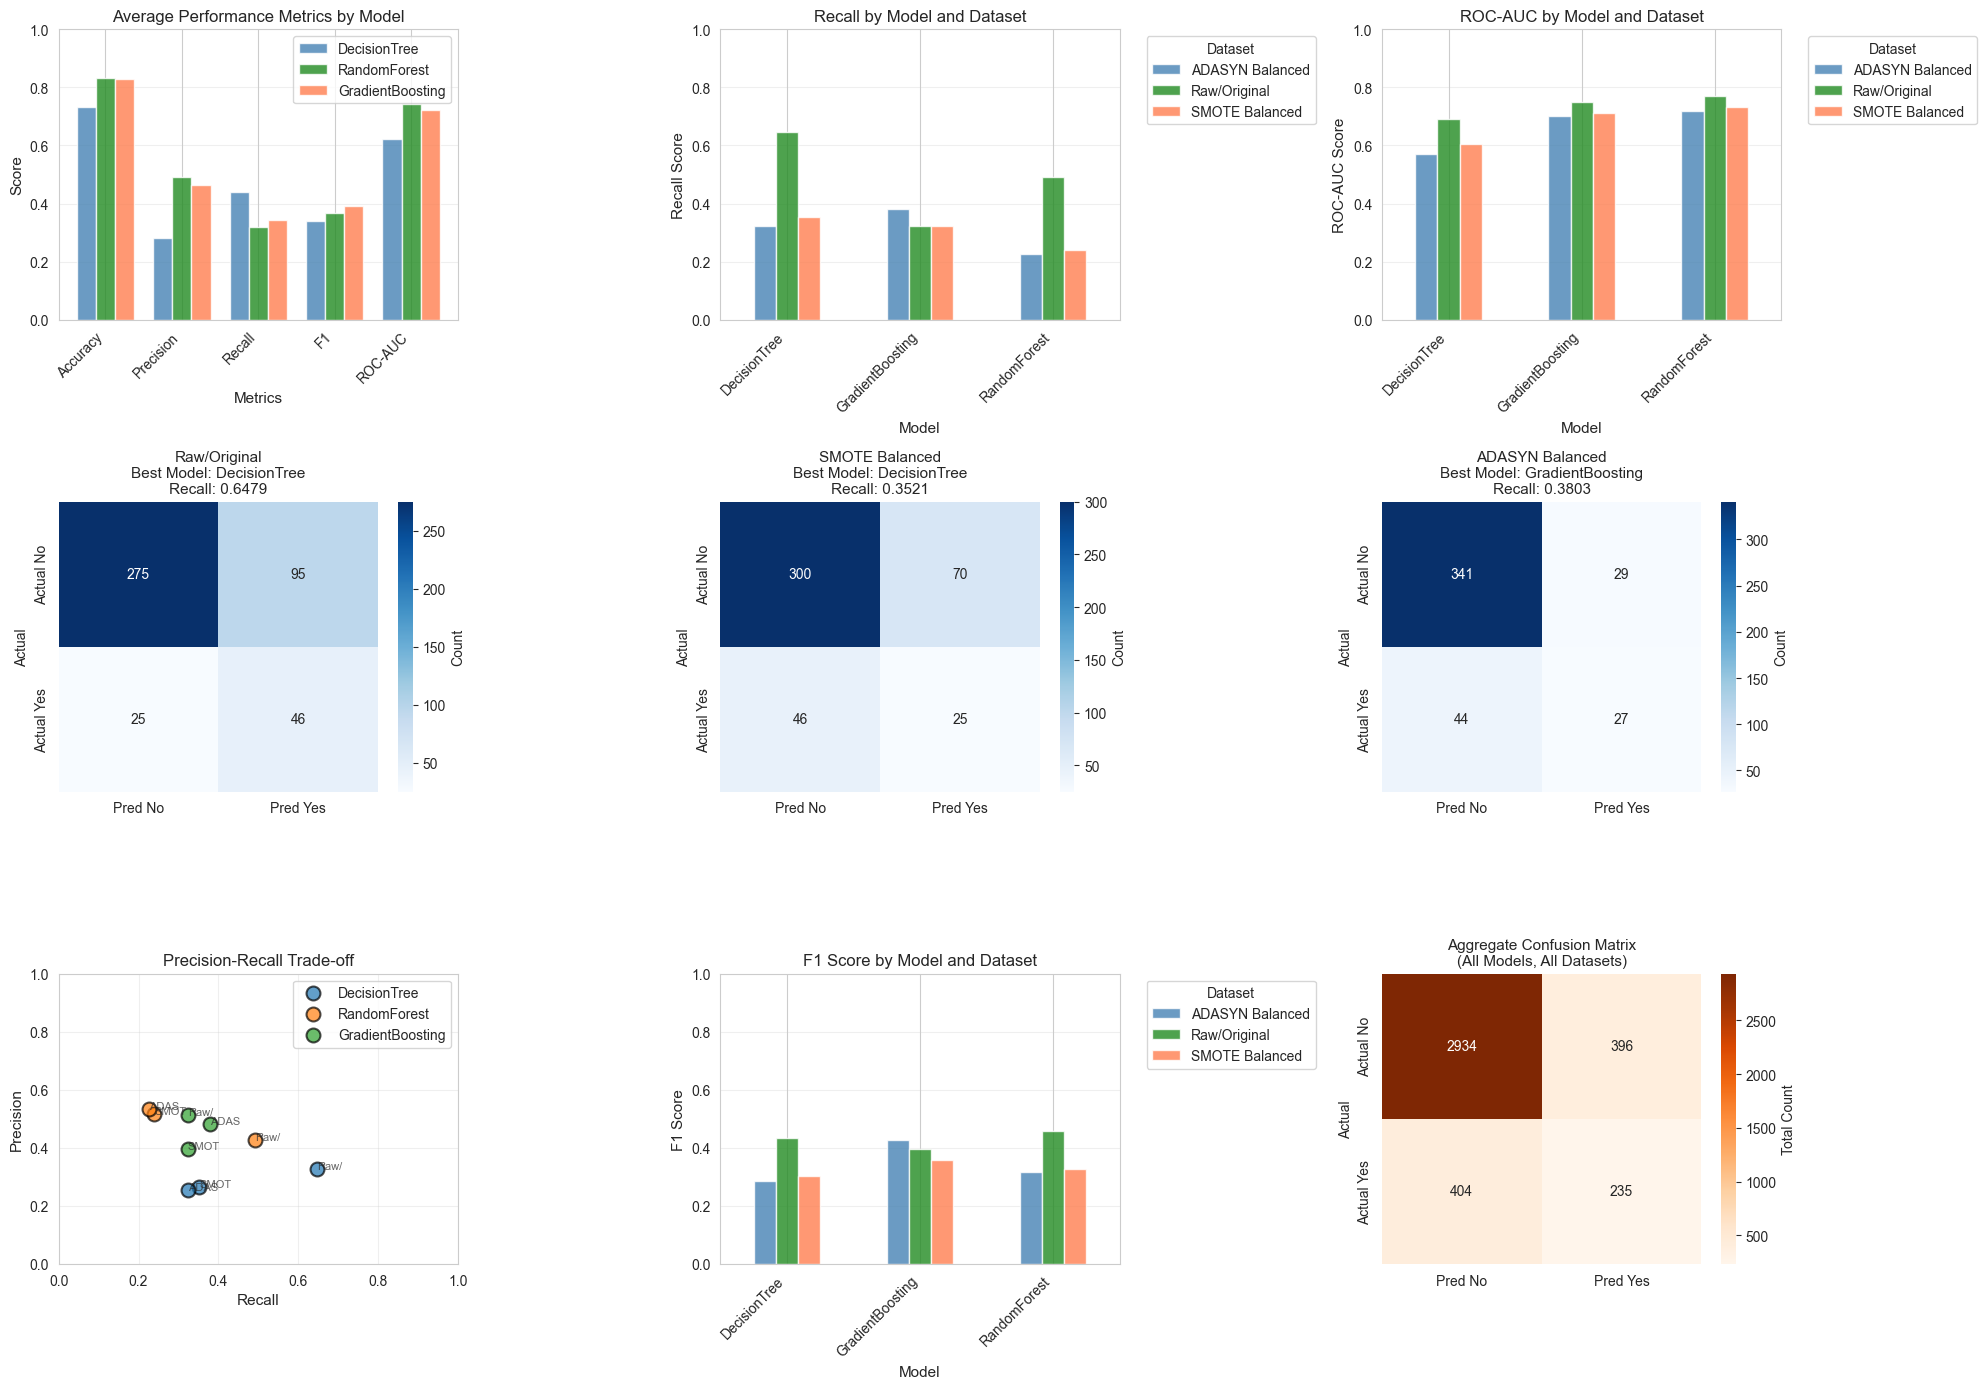


DETAILED MODEL COMPARISON TABLE

Sorted by Recall (Descending):
           model         dataset  accuracy  precision   recall       f1  roc_auc  tp  fn  fp  tn
    DecisionTree    Raw/Original  0.727891   0.326241 0.647887 0.433962 0.692977  46  25  95 275
    RandomForest    Raw/Original  0.811791   0.426829 0.492958 0.457516 0.769661  35  36  47 323
GradientBoosting ADASYN Balanced  0.834467   0.482143 0.380282 0.425197 0.701675  27  44  29 341
    DecisionTree  SMOTE Balanced  0.736961   0.263158 0.352113 0.301205 0.606395  25  46  70 300
    DecisionTree ADASYN Balanced  0.736961   0.252747 0.323944 0.283951 0.570080  23  48  68 302
GradientBoosting    Raw/Original  0.841270   0.511111 0.323944 0.396552 0.748763  23  48  22 348
GradientBoosting  SMOTE Balanced  0.811791   0.396552 0.323944 0.356589 0.713095  23  48  35 335
    RandomForest  SMOTE Balanced  0.841270   0.515152 0.239437 0.326923 0.733993  17  54  16 354
    RandomForest ADASYN Balanced  0.843537   0.533333 0.225352

In [20]:
# ============================================================
# Step 8: Comprehensive Model Comparison
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create comprehensive comparison visualizations
fig = plt.figure(figsize=(20, 14))

# 1. Metrics Comparison Bar Chart (All Metrics)
ax1 = plt.subplot(3, 3, 1)
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
x = np.arange(len(metrics_to_plot))
width = 0.25

model_list = metrics_df['model'].unique()
colors = ['steelblue', 'forestgreen', 'coral']

for i, model in enumerate(model_list):
    model_data = metrics_df[metrics_df['model'] == model]
    values = [model_data[metric].mean() for metric in metrics_to_plot]
    ax1.bar(x + i*width, values, width, label=model, alpha=0.8, color=colors[i])

ax1.set_xlabel('Metrics', fontsize=11)
ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('Average Performance Metrics by Model', fontsize=12, fontweight='bold')
ax1.set_xticks(x + width)
ax1.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# 2. Recall Comparison (Focus Metric)
ax2 = plt.subplot(3, 3, 2)
recall_data = metrics_df.pivot(index='model', columns='dataset', values='recall')
recall_data.plot(kind='bar', ax=ax2, color=['steelblue', 'forestgreen', 'coral'], alpha=0.8)
ax2.set_xlabel('Model', fontsize=11)
ax2.set_ylabel('Recall Score', fontsize=11)
ax2.set_title('Recall by Model and Dataset', fontsize=12, fontweight='bold')
ax2.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1])
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. ROC-AUC Comparison
ax3 = plt.subplot(3, 3, 3)
auc_data = metrics_df.pivot(index='model', columns='dataset', values='roc_auc')
auc_data.plot(kind='bar', ax=ax3, color=['steelblue', 'forestgreen', 'coral'], alpha=0.8)
ax3.set_xlabel('Model', fontsize=11)
ax3.set_ylabel('ROC-AUC Score', fontsize=11)
ax3.set_title('ROC-AUC by Model and Dataset', fontsize=12, fontweight='bold')
ax3.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 1])
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4-6. Confusion Matrices for Best Model per Dataset (Based on Recall)
ax4 = plt.subplot(3, 3, 4)
ax5 = plt.subplot(3, 3, 5)
ax6 = plt.subplot(3, 3, 6)

dataset_keys = ['raw', 'smote', 'adasyn']
axes_cm = [ax4, ax5, ax6]

for idx, dataset_key in enumerate(dataset_keys):
    dataset_name = training_sets[dataset_key]['name']
    dataset_data = metrics_df[metrics_df['dataset'] == dataset_name]
    
    # Find best model by recall for this dataset
    best_idx = dataset_data['recall'].idxmax()
    best_row = dataset_data.loc[best_idx]
    best_model = best_row['model']
    
    # Get confusion matrix
    cm = np.array([[best_row['tn'], best_row['fp']],
                   [best_row['fn'], best_row['tp']]])
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes_cm[idx],
               xticklabels=['Pred No', 'Pred Yes'],
               yticklabels=['Actual No', 'Actual Yes'],
               cbar_kws={'label': 'Count'})
    axes_cm[idx].set_title(f'{dataset_name}\nBest Model: {best_model}\nRecall: {best_row["recall"]:.4f}', 
                          fontsize=11, fontweight='bold')
    axes_cm[idx].set_ylabel('Actual', fontsize=10)

# 7. Precision-Recall Trade-off
ax7 = plt.subplot(3, 3, 7)
for model in model_list:
    model_data = metrics_df[metrics_df['model'] == model]
    ax7.scatter(model_data['recall'], model_data['precision'], 
               label=model, s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
    
    # Add dataset labels
    for _, row in model_data.iterrows():
        ax7.annotate(row['dataset'][:4], (row['recall'], row['precision']), 
                    fontsize=8, alpha=0.7)

ax7.set_xlabel('Recall', fontsize=11)
ax7.set_ylabel('Precision', fontsize=11)
ax7.set_title('Precision-Recall Trade-off', fontsize=12, fontweight='bold')
ax7.legend()
ax7.grid(alpha=0.3)
ax7.set_xlim([0, 1])
ax7.set_ylim([0, 1])

# 8. F1 Score Comparison
ax8 = plt.subplot(3, 3, 8)
f1_data = metrics_df.pivot(index='model', columns='dataset', values='f1')
f1_data.plot(kind='bar', ax=ax8, color=['steelblue', 'forestgreen', 'coral'], alpha=0.8)
ax8.set_xlabel('Model', fontsize=11)
ax8.set_ylabel('F1 Score', fontsize=11)
ax8.set_title('F1 Score by Model and Dataset', fontsize=12, fontweight='bold')
ax8.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
ax8.grid(axis='y', alpha=0.3)
ax8.set_ylim([0, 1])
plt.setp(ax8.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 9. Confusion Matrix Summary (Total counts across all models)
ax9 = plt.subplot(3, 3, 9)
total_cm = np.array([
    [metrics_df['tn'].sum(), metrics_df['fp'].sum()],
    [metrics_df['fn'].sum(), metrics_df['tp'].sum()]
])
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Oranges', ax=ax9,
           xticklabels=['Pred No', 'Pred Yes'],
           yticklabels=['Actual No', 'Actual Yes'],
           cbar_kws={'label': 'Total Count'})
ax9.set_title('Aggregate Confusion Matrix\n(All Models, All Datasets)', 
             fontsize=11, fontweight='bold')
ax9.set_ylabel('Actual', fontsize=10)

plt.tight_layout()
plt.show()

# Print detailed comparison table
print("\n" + "=" * 70)
print("DETAILED MODEL COMPARISON TABLE")
print("=" * 70)
print("\nSorted by Recall (Descending):")
comparison_sorted = metrics_df.sort_values('recall', ascending=False)
display_cols_full = ['model', 'dataset', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'tp', 'fn', 'fp', 'tn']
print(comparison_sorted[display_cols_full].to_string(index=False))


## Step 9: Recall-Focused Analysis

Detailed analysis focusing on recall performance, which is critical for identifying employees at risk of attrition.


In [21]:
# ============================================================
# Step 9: Recall-Focused Analysis
# ============================================================

print("=" * 70)
print("RECALL-FOCUSED ANALYSIS")
print("=" * 70)
print("\nRecall is the most critical metric for HR attrition prediction.")
print("It measures the proportion of employees who will leave that we correctly identify.")
print("High recall means we catch more at-risk employees, enabling proactive interventions.\n")

# Find best model overall by recall
best_overall_recall = metrics_df.loc[metrics_df['recall'].idxmax()]
print("=" * 70)
print("BEST MODEL OVERALL (Highest Recall)")
print("=" * 70)
print(f"Model:        {best_overall_recall['model']}")
print(f"Dataset:      {best_overall_recall['dataset']}")
print(f"Recall:       {best_overall_recall['recall']:.4f}")
print(f"Precision:    {best_overall_recall['precision']:.4f}")
print(f"F1 Score:     {best_overall_recall['f1']:.4f}")
print(f"ROC-AUC:      {best_overall_recall['roc_auc']:.4f}")
print(f"\nConfusion Matrix:")
print(f"  True Positives (TP):  {best_overall_recall['tp']} - Correctly identified employees who will leave")
print(f"  False Negatives (FN): {best_overall_recall['fn']} - Employees who will leave but were missed")
print(f"  False Positives (FP): {best_overall_recall['fp']} - Employees incorrectly flagged as leaving")
print(f"  True Negatives (TN):  {best_overall_recall['tn']} - Correctly identified employees who will stay")

# Calculate recall improvement metrics
print("\n" + "=" * 70)
print("RECALL ANALYSIS BY MODEL")
print("=" * 70)
for model in metrics_df['model'].unique():
    model_data = metrics_df[metrics_df['model'] == model]
    print(f"\n{model}:")
    print(f"  Mean Recall: {model_data['recall'].mean():.4f}")
    print(f"  Best Recall: {model_data['recall'].max():.4f} ({model_data.loc[model_data['recall'].idxmax(), 'dataset']})")
    print(f"  Worst Recall: {model_data['recall'].min():.4f} ({model_data.loc[model_data['recall'].idxmin(), 'dataset']})")
    print(f"  Recall Range: {model_data['recall'].max() - model_data['recall'].min():.4f}")

print("\n" + "=" * 70)
print("RECALL ANALYSIS BY DATASET")
print("=" * 70)
for dataset in metrics_df['dataset'].unique():
    dataset_data = metrics_df[metrics_df['dataset'] == dataset]
    print(f"\n{dataset}:")
    print(f"  Mean Recall: {dataset_data['recall'].mean():.4f}")
    print(f"  Best Model: {dataset_data.loc[dataset_data['recall'].idxmax(), 'model']} (Recall: {dataset_data['recall'].max():.4f})")
    print(f"  Worst Model: {dataset_data.loc[dataset_data['recall'].idxmin(), 'model']} (Recall: {dataset_data['recall'].min():.4f})")

# Business impact analysis
print("\n" + "=" * 70)
print("BUSINESS IMPACT ANALYSIS (Based on Best Model)")
print("=" * 70)
total_employees_at_risk = best_overall_recall['tp'] + best_overall_recall['fn']
employees_caught = best_overall_recall['tp']
employees_missed = best_overall_recall['fn']

print(f"\nTest Set Analysis:")
print(f"  Total employees who will leave: {total_employees_at_risk}")
print(f"  Employees correctly identified: {employees_caught} ({best_overall_recall['recall']*100:.1f}%)")
print(f"  Employees missed: {employees_missed} ({(1-best_overall_recall['recall'])*100:.1f}%)")
print(f"  False alarms (FP): {best_overall_recall['fp']} employees incorrectly flagged")

# Compare with baseline (worst recall)
worst_recall = metrics_df.loc[metrics_df['recall'].idxmin()]
improvement = best_overall_recall['recall'] - worst_recall['recall']
print(f"\nImprovement over worst model:")
print(f"  Worst model recall: {worst_recall['recall']:.4f} ({worst_recall['model']} on {worst_recall['dataset']})")
print(f"  Best model recall: {best_overall_recall['recall']:.4f} ({best_overall_recall['model']} on {best_overall_recall['dataset']})")
print(f"  Absolute improvement: {improvement:.4f} ({improvement*100:.1f} percentage points)")
print(f"  Relative improvement: {(improvement/worst_recall['recall']*100):.1f}%")

# Recommendations
print("\n" + "=" * 70)
print("RECOMMENDATIONS BASED ON RECALL ANALYSIS")
print("=" * 70)
print(f"\n1. Best Model for Production: {best_overall_recall['model']} trained on {best_overall_recall['dataset']}")
print(f"   - Highest recall: {best_overall_recall['recall']:.4f}")
print(f"   - Catches {best_overall_recall['recall']*100:.1f}% of employees who will leave")

if best_overall_recall['precision'] < 0.5:
    print(f"   - Warning: Low precision ({best_overall_recall['precision']:.4f}) means many false alarms")
    print(f"   - Consider precision-recall trade-off for cost optimization")

print(f"\n2. Model Performance Ranking (by Recall):")
recall_ranking = metrics_df.sort_values('recall', ascending=False)
for i, (idx, row) in enumerate(recall_ranking.iterrows(), 1):
    print(f"   {i}. {row['model']:20s} on {row['dataset']:20s} - Recall: {row['recall']:.4f}")

print(f"\n3. Dataset Performance:")
for dataset in metrics_df['dataset'].unique():
    dataset_data = metrics_df[metrics_df['dataset'] == dataset]
    avg_recall = dataset_data['recall'].mean()
    print(f"   {dataset:20s} - Average Recall: {avg_recall:.4f}")

print("\n" + "=" * 70)


RECALL-FOCUSED ANALYSIS

Recall is the most critical metric for HR attrition prediction.
It measures the proportion of employees who will leave that we correctly identify.
High recall means we catch more at-risk employees, enabling proactive interventions.

BEST MODEL OVERALL (Highest Recall)
Model:        DecisionTree
Dataset:      Raw/Original
Recall:       0.6479
Precision:    0.3262
F1 Score:     0.4340
ROC-AUC:      0.6930

Confusion Matrix:
  True Positives (TP):  46 - Correctly identified employees who will leave
  False Negatives (FN): 25 - Employees who will leave but were missed
  False Positives (FP): 95 - Employees incorrectly flagged as leaving
  True Negatives (TN):  275 - Correctly identified employees who will stay

RECALL ANALYSIS BY MODEL

DecisionTree:
  Mean Recall: 0.4413
  Best Recall: 0.6479 (Raw/Original)
  Worst Recall: 0.3239 (ADASYN Balanced)
  Recall Range: 0.3239

RandomForest:
  Mean Recall: 0.3192
  Best Recall: 0.4930 (Raw/Original)
  Worst Recall: 0.225

## Step 10: Feature Importance Summary

Display feature importance rankings for all model-dataset combinations.


In [22]:
# ============================================================
# Step 10: Feature Importance Summary
# ============================================================

print("=" * 70)
print("FEATURE IMPORTANCE STORAGE")
print("=" * 70)
print("\nStructure: {model_name: {dataset: Series of ranked features}}")

# Display top 10 features for each model-dataset combination
for model_name in ['DecisionTree', 'RandomForest', 'GradientBoosting']:
    print(f"\n{'='*70}")
    print(f"{model_name.upper()}")
    print("=" * 70)
    
    for dataset_key in ['raw', 'smote', 'adasyn']:
        dataset_name = training_sets[dataset_key]['name']
        importance = all_feature_importances[model_name][dataset_key]
        
        print(f"\n{dataset_name} - Top 10 Features:")
        top_features = importance.head(10)
        for i, (feature, imp_value) in enumerate(top_features.items(), 1):
            print(f"  {i:2d}. {feature:30s} : {imp_value:.4f}")


FEATURE IMPORTANCE STORAGE

Structure: {model_name: {dataset: Series of ranked features}}

DECISIONTREE

Raw/Original - Top 10 Features:
   1. TotalWorkingYears              : 0.3277
   2. OverTime                       : 0.1959
   3. StockOptionLevel               : 0.1118
   4. NumCompaniesWorked             : 0.0702
   5. DistanceFromHome               : 0.0638
   6. EnvironmentSatisfaction        : 0.0535
   7. WorkLifeBalance                : 0.0434
   8. MaritalStatus_Married          : 0.0375
   9. CompanyTenureShare             : 0.0351
  10. JobRoleBucket_Sales            : 0.0309

SMOTE Balanced - Top 10 Features:
   1. StockOptionLevel               : 0.1921
   2. TotalWorkingYears              : 0.1476
   3. PercentSalaryHike              : 0.0751
   4. CompanyTenureShare             : 0.0732
   5. WorkLifeBalance                : 0.0695
   6. NumCompaniesWorked             : 0.0682
   7. DistanceFromHome               : 0.0605
   8. EnvironmentSatisfaction        : 0.0605


## Step 11: Best Estimators Storage

Display summary of stored best estimators for all model-dataset combinations.


In [23]:
# ============================================================
# Step 11: Best Estimators Storage
# ============================================================

print("=" * 70)
print("BEST ESTIMATORS STORAGE")
print("=" * 70)
print("\nStructure: {model_name: {dataset: best_estimator}}")

# Display summary
for model_name in ['DecisionTree', 'RandomForest', 'GradientBoosting']:
    print(f"\n{model_name}:")
    for dataset_key in ['raw', 'smote', 'adasyn']:
        dataset_name = training_sets[dataset_key]['name']
        estimator = best_estimators[model_name][dataset_key]
        print(f"  {dataset_name}: {type(estimator).__name__}")
        print(f"    Parameters: {estimator.get_params()}")

print(f"\n{'='*70}")
print("All best estimators stored in 'best_estimators' dictionary")
print("Access example: best_estimators['DecisionTree']['raw']")
print("=" * 70)


BEST ESTIMATORS STORAGE

Structure: {model_name: {dataset: best_estimator}}

DecisionTree:
  Raw/Original: DecisionTreeClassifier
    Parameters: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
  SMOTE Balanced: DecisionTreeClassifier
    Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
  ADASYN Balanced: DecisionTreeClassifier
    Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impuri

## Step 12: Summary

All comprehensive comparisons, visualizations, and recall-focused analysis are complete.


In [24]:
# ============================================================
# Step 12: Summary
# ============================================================

print("=" * 70)
print("NOTEBOOK SUMMARY")
print("=" * 70)
print("\nAll model training, evaluation, and comparison complete!")
print("\nKey Sections Completed:")
print("  1. Data loading and three dataset preparation (raw, SMOTE, ADASYN)")
print("  2. Decision Tree with GridSearchCV (3 datasets)")
print("  3. Random Forest with GridSearchCV (3 datasets)")
print("  4. Gradient Boosting with GridSearchCV (3 datasets)")
print("  5. Comprehensive metrics table with all metrics")
print("  6. Comprehensive model comparison visualizations")
print("  7. Recall-focused analysis and recommendations")
print("  8. Feature importance summaries")
print("  9. Best estimators storage")
print("\nAll metrics tracked:")
print("  - Accuracy, Precision, Recall, F1 Score, ROC-AUC")
print("  - Confusion Matrix components (TN, FP, FN, TP)")
print("\nAnalysis Focus:")
print("  - Primary focus on Recall (critical for HR attrition)")
print("  - Comprehensive comparison across all models and datasets")
print("  - Business impact analysis and recommendations")
print("\n" + "=" * 70)


NOTEBOOK SUMMARY

All model training, evaluation, and comparison complete!

Key Sections Completed:
  1. Data loading and three dataset preparation (raw, SMOTE, ADASYN)
  2. Decision Tree with GridSearchCV (3 datasets)
  3. Random Forest with GridSearchCV (3 datasets)
  4. Gradient Boosting with GridSearchCV (3 datasets)
  5. Comprehensive metrics table with all metrics
  6. Comprehensive model comparison visualizations
  7. Recall-focused analysis and recommendations
  8. Feature importance summaries
  9. Best estimators storage

All metrics tracked:
  - Accuracy, Precision, Recall, F1 Score, ROC-AUC
  - Confusion Matrix components (TN, FP, FN, TP)

Analysis Focus:
  - Primary focus on Recall (critical for HR attrition)
  - Comprehensive comparison across all models and datasets
  - Business impact analysis and recommendations

